___
## Springboard Capstone 1: Liver Disease Prediction
### Learning Model Comparison with Data Preprocessing and Dimensionality Reduction

Nils Madsen
___

### Overview of Rationale and Approach

The predictors in this problem are continuous, quantitative variables (with the exception of sex). As can be seen in the data storytelling, there is some degree of covariance among different variables. In order to mitigate the effect of this covariance on the success of the learning models (especially logistic regression), it would be best to produce a set of uncorrelated predictor variables.

Principal Component Analysis (PCA) is a common and effective tool for returning derived variables (components) that are uncorrelated. PCA also has the benefit of allowing for dimensionality reduction while keeping most of the information in the dataset, which may improve the performance of the learning models. 

However, correct implementation of PCA requires that the data be unskewed, centered, and equally scaled between variables. The overall strategy here will be:

1. Unskew the data using various transormations 

2. Standardize the data

3. Use PCA to produce uncorrelated variables, possibly with dimensionality reduction

4. Train various learning models, evaluating the effectiveness of each with cross-validation

5. Get an idea for the performance of the model(s) on new data by applying the trained model(s) to the test dataset
___

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid')

In [3]:
# import cleaned data
liver_df = pd.read_csv('indian_liver_dataset_clean.csv', index_col=0)
print(liver_df.info())

# convert sex and disease group variables to numeric form
liver_df.sex = liver_df.sex.map({'Male': 1, 'Female': 0})
liver_df['liver disease'] = liver_df['liver disease'].astype('int')
liver_df.head(10)

# convert sex, age, ALP, ALT, and AST to float64
liver_df.sex = liver_df.sex.astype(np.float64)
liver_df.age = liver_df.age.astype(np.float64)
liver_df.ALP = liver_df.ALP.astype(np.float64)
liver_df.ALT = liver_df.ALT.astype(np.float64)
liver_df.AST = liver_df.AST.astype(np.float64)
print(liver_df.info())
liver_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
liver disease    583 non-null bool
dtypes: bool(1), float64(5), int64(4), object(1)
memory usage: 50.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null float64
sex              583 non-null float64
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null float64
ALT              583 non-null float64
AST              583 non-null float64
total protein    583 non-null float64
alb

,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,liver disease
0,65.0,0.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,1.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,1.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,1.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,1.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [4]:
# create train and test datasets
from sklearn.model_selection import train_test_split

X = liver_df.copy()
y = X.pop('liver disease')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

___
### Skew correction

First, visualize and correct for skewed distributions by transforming each variable as needed. To avoid any possibility of overfitting, decisions about which transformation to use for each variable will be made solely based on the training data.
___

In [5]:
def vis_transforms(df, variable, bins=20):
    ''' Visualize distribution after skew-correcting transforms, in order of increasing strength'''
    array = np.array(df[variable])
    
    # Untransformed
    plt.hist(array, bins=bins)
    plt.title('{} - Untransformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(array))
    
    # Square root
    plt.hist(np.sqrt(array), bins=bins)
    plt.title('{} - Square root transformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(np.sqrt(array)))
    
    # Log
    plt.hist(np.log(array), bins=bins)
    plt.title('{} - Log transformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(np.log(array)))
    
    # Box-Cox
    bc_transformed, bestlambda = stats.boxcox(array)
    plt.hist(bc_transformed, bins=bins)
    plt.title('{} - Box-Cox transformed (lambda = {})'.format(variable, round(bestlambda,2)))
    plt.show()
    print('Skew: ', stats.skew(bc_transformed))
    
    # Reciprocal
    plt.hist(np.reciprocal(array), bins=bins)
    plt.title('{} - reciprocal transformed'.format(variable))
    plt.margins(0.1)
    plt.show()
    print('Skew: ', stats.skew(np.reciprocal(array)))

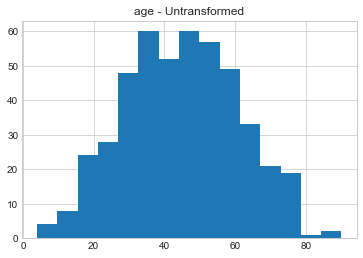

Skew:  0.053335562011068406


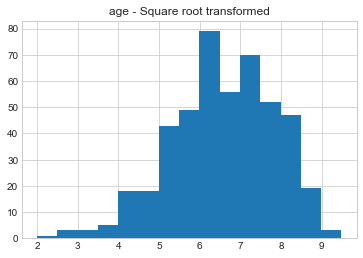

Skew:  -0.4556579802324828


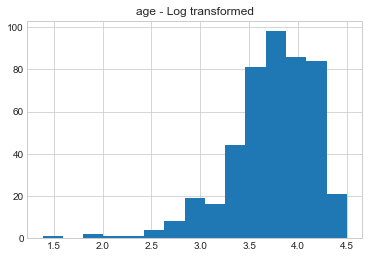

Skew:  -1.2513538991630566


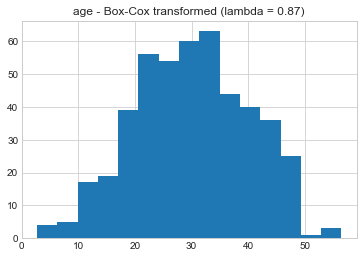

Skew:  -0.0637970431464335


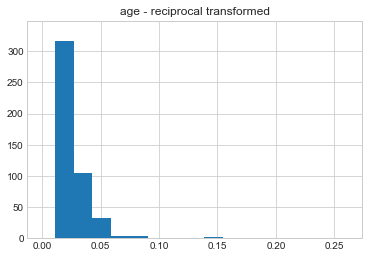

Skew:  5.852757789723


In [6]:
# Age
vis_transforms(X_train, 'age', bins=15)

Age is not skewed in this dataset.

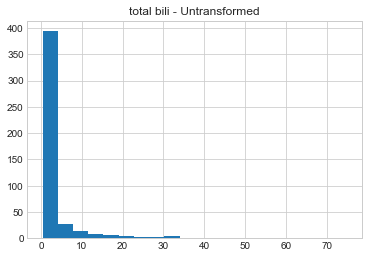

Skew:  5.294406293137899


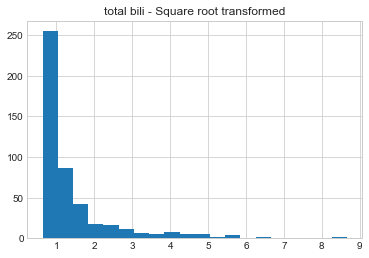

Skew:  2.7270513970636894


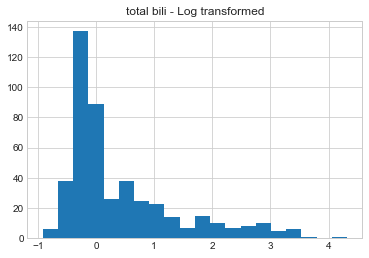

Skew:  1.4483643371345325


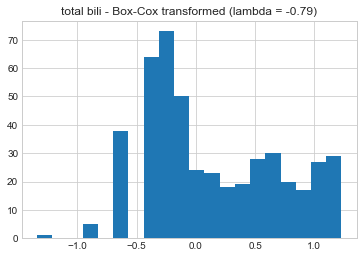

Skew:  0.36268989117353123


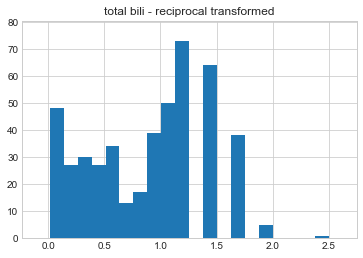

Skew:  -0.14913085909520593


In [7]:
# total bilirubin
vis_transforms(X_train, 'total bili')

Total bilirubin is heavily skewed. Reciprocal transformation returns the best result.

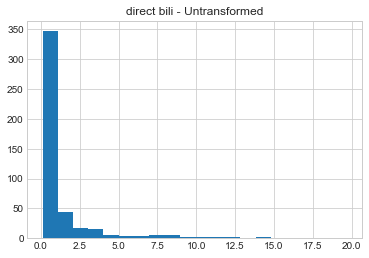

Skew:  3.504097808014282


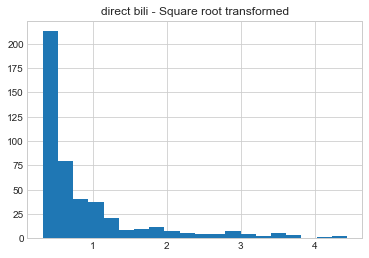

Skew:  2.156091465987083


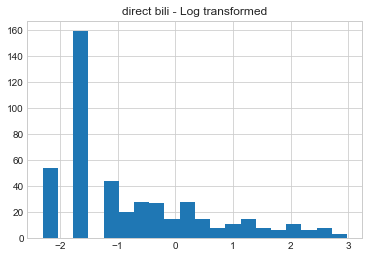

Skew:  0.9339301150935337


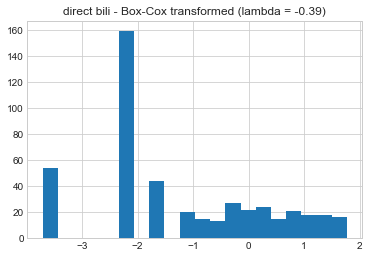

Skew:  0.18858701956109936


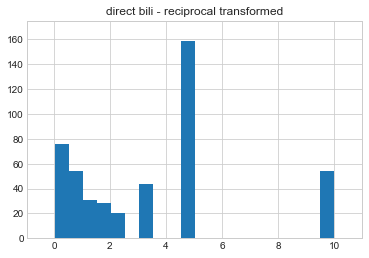

Skew:  0.8024760620729451


In [8]:
# direct bilirubin
vis_transforms(X_train, 'direct bili')

Attempting to unskew direct bili with any transformation stronger than square root causes the distribution to be broken up into discrete values. This is due to inadequate precision at lower values of direct bili (usually only to the scale of 0.1). Box-Cox transformation is the best that can be done with this variable, but it also may be best not to use this variable in the model due to the inability to adequately correct for the skew.

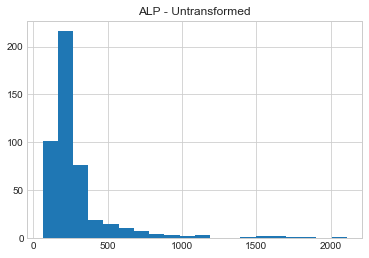

Skew:  3.8088233204999797


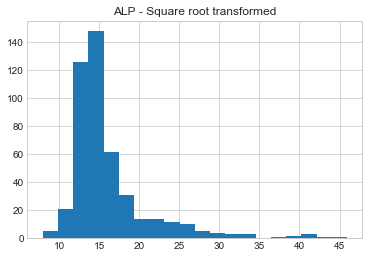

Skew:  2.4890513460369332


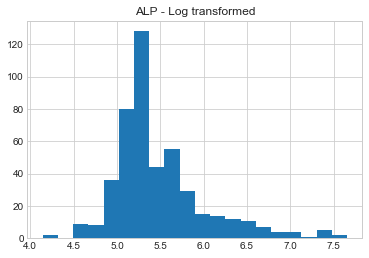

Skew:  1.3841007708948248


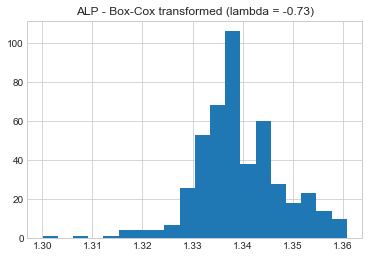

Skew:  -0.06114860574001558


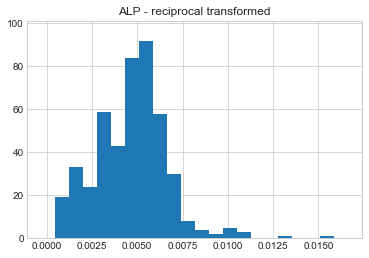

Skew:  0.6494061898595258


In [9]:
# ALP
vis_transforms(X_train, 'ALP', bins=20)

ALP is also heavily skewed, but fortunately the issue of creating discrete values at the low end does not appear here. Box-Cox transformation corrects best for the skew.

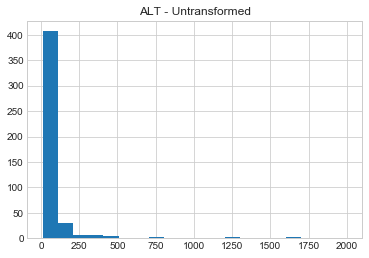

Skew:  6.4336727986558815


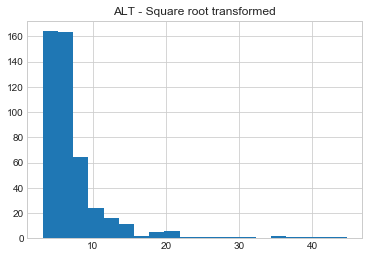

Skew:  3.8218565014194845


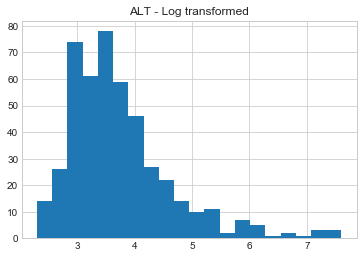

Skew:  1.491082561645322


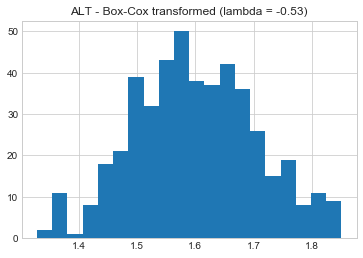

Skew:  0.08564940487227629


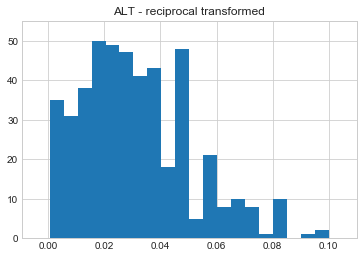

Skew:  0.7210615160756626


In [10]:
# ALT
vis_transforms(X_train, 'ALT')

ALT is heavily skewed as well. Box-Cox is able to correct well for the skew.

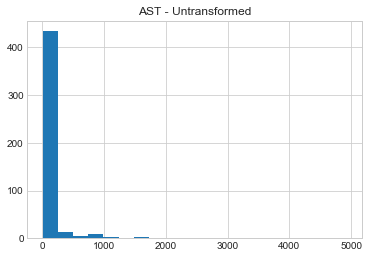

Skew:  10.02368723863904


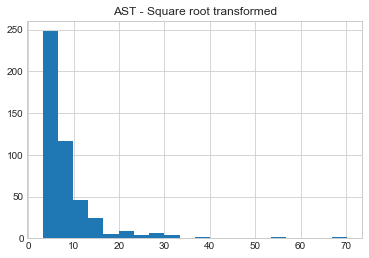

Skew:  4.0950996925143075


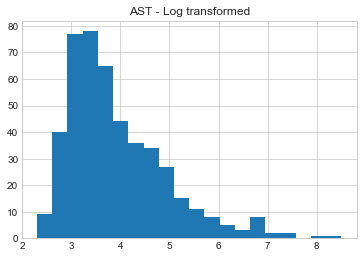

Skew:  1.2546281679266615


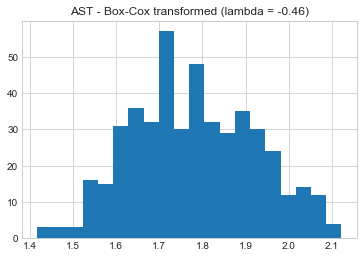

Skew:  0.12014449564816772


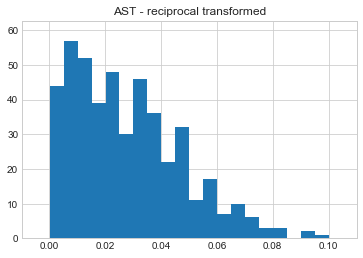

Skew:  0.7504521502622347


In [11]:
# AST
vis_transforms(X_train, 'AST')

AST is the most skewed of all variables in the dataset, but Box-Cox is able to correct well for the skew.

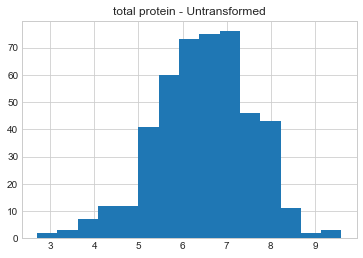

Skew:  -0.27901216823292635


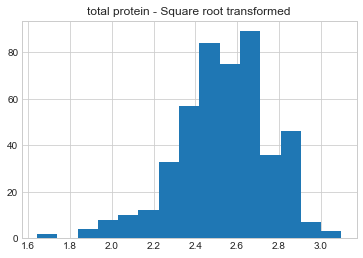

Skew:  -0.5869503124927192


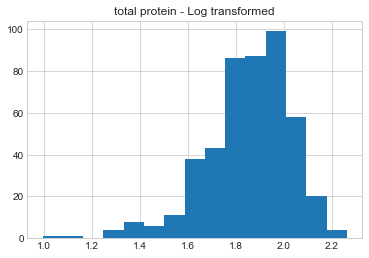

Skew:  -0.9429170237589574


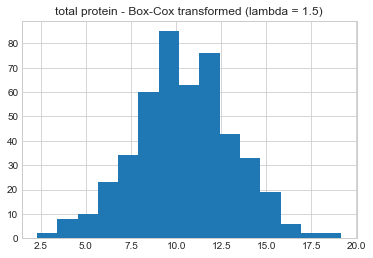

Skew:  -0.0031432598608376414


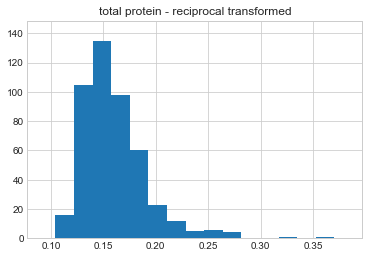

Skew:  1.890418565792


In [12]:
# total protein
vis_transforms(X_train, 'total protein', bins=15)

Total Protein is only mildly skewed. Box-Cox is the best transformation here as well.

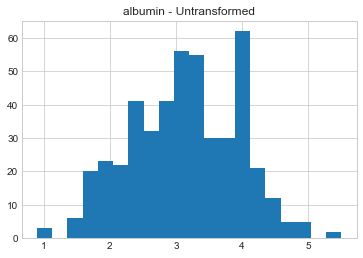

Skew:  -0.05548634995066117


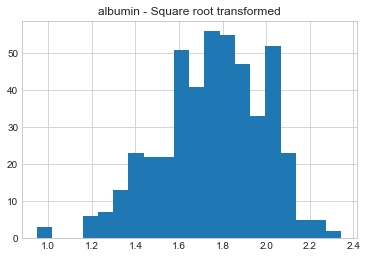

Skew:  -0.41758199864272694


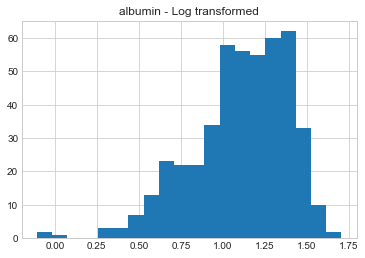

Skew:  -0.8608128348707551


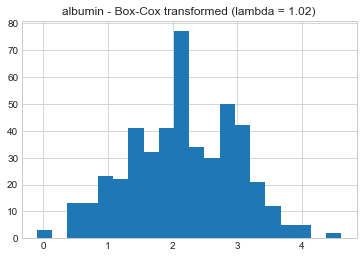

Skew:  -0.040502570751705824


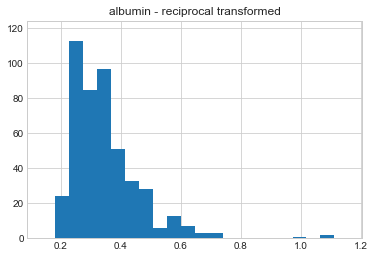

Skew:  2.307269587227202


In [13]:
# albumin
vis_transforms(X_train, 'albumin')

Albumin is not skewed in this dataset.

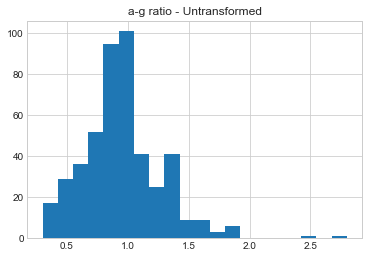

Skew:  0.9678062004917939


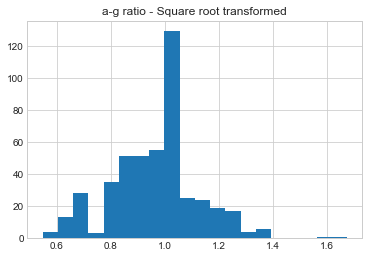

Skew:  0.235957977592239


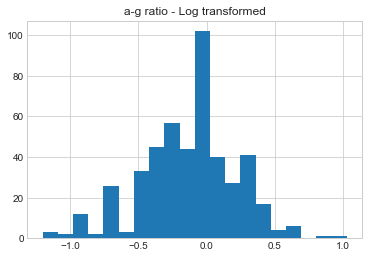

Skew:  -0.38227198920056854


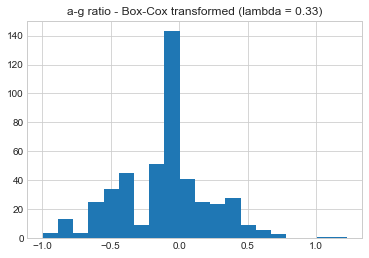

Skew:  0.01415389429314421


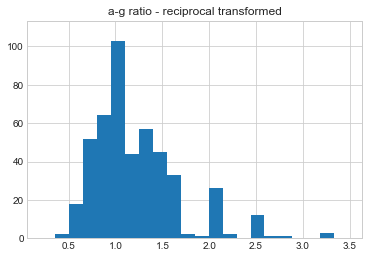

Skew:  1.5672054212902842


In [14]:
# a-g ratio
vis_transforms(X_train, 'a-g ratio')

A-g ratio is slightly skewed in the data, and Box-Cox performs best to correct for this.

___
### Applying the deskewing transformations

Sklearn has not yet implemented a power-transforming object that can be used within pipelines. This feature is slated for the 0.20 release: http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PowerTransformer.html

As a result, the transformations here will be applied manually to the training data. Then, the parameters found to best tranform the training data will also be used to transform the test data. This is to simulate how new data will be treated in a real-world application.
___

Box-Cox transform lambdas: 
 {'direct bili': -0.3855724959219744, 'ALP': -0.7321515321560144, 'ALT': -0.5309181768201177, 'AST': -0.46206296811584124, 'total protein': 1.5001537348499752, 'a-g ratio': 0.3272744073867761}


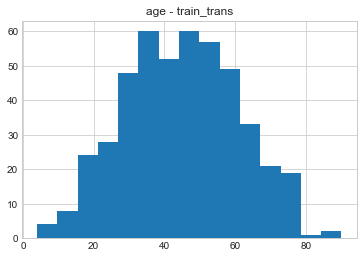

Skew:  0.053335562011068406


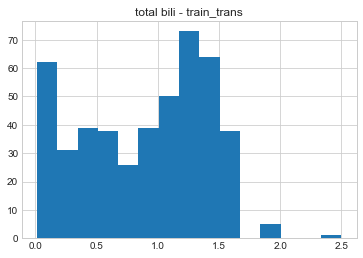

Skew:  -0.14913085909520593


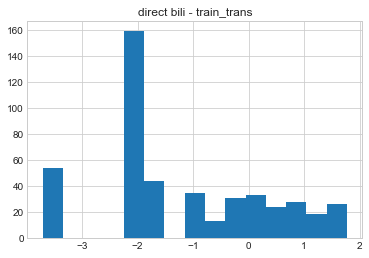

Skew:  0.18858701956109936


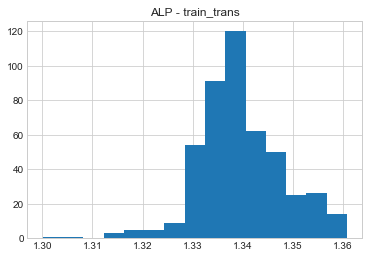

Skew:  -0.06114860574001558


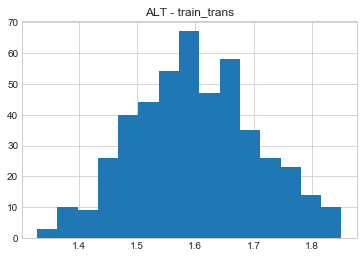

Skew:  0.08564940487227629


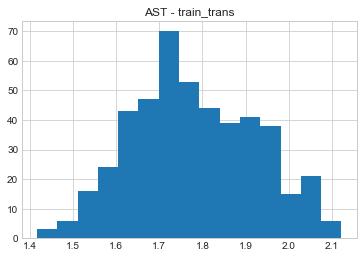

Skew:  0.12014449564816772


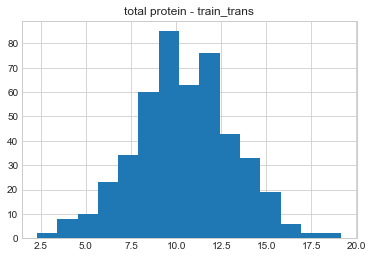

Skew:  -0.0031432598608376414


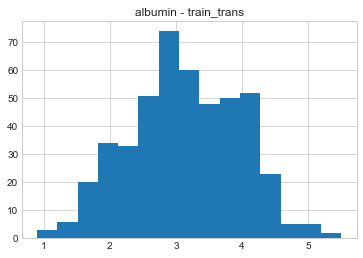

Skew:  -0.05548634995066117


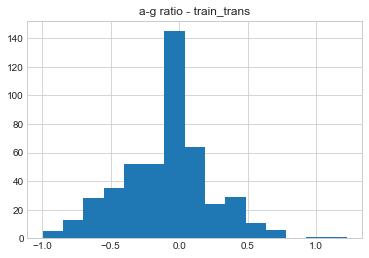

Skew:  0.01415389429314421


In [15]:
# apply best transformations to create unskewed training dataset
train_trans = X_train.copy()

train_trans['total bili'] = np.reciprocal(X_train['total bili'])

box_cox_variables = ['direct bili', 'ALP', 'ALT', 'AST', 'total protein', 'a-g ratio']
bestlambdas = dict()

for variable in box_cox_variables:
    train_trans[variable], bestlambdas[variable] = stats.boxcox(X_train[variable])

print('Box-Cox transform lambdas: \n', bestlambdas)

# visualize distributions of variables in transformed training dataset
for variable in ('age', 'total bili', 'direct bili', 'ALP', 
                 'ALT', 'AST', 'total protein', 'albumin', 'a-g ratio'):
    array = np.array(train_trans[variable])
    plt.hist(array, bins=15)
    plt.title('{} - train_trans'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(array))

In [16]:
# deskew test dataset
test_trans = X_test.copy()

test_trans['total bili'] = np.reciprocal(X_test['total bili'])

for variable in box_cox_variables:
    test_trans[variable] = stats.boxcox(X_test[variable], lmbda=bestlambdas[variable])

___
### Scaling and PCA

Scaling and PCA both have corresponding pipeline-usable objects in sklearn. However, first it would be good to visualize the effect of PCA on the training data to see how the explained variance decreases with increasing dimensions.

___

In [17]:
# scale training dataset
train_scaled = train_trans.copy()
del train_scaled['sex']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns = train_scaled.columns
train_scaled = scaler.fit_transform(train_scaled)
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns = columns

train_scaled.head()

,age,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio
0,-1.173561,0.384292,-0.656917,-0.919092,-1.419254,-2.102160,0.461489,0.455014,0.284258
1,0.935308,-1.581375,1.575956,2.113222,1.122733,1.331413,-0.288434,-0.408427,-0.364001
2,-0.305203,-1.256142,1.107652,0.896032,2.211689,2.161133,0.174952,0.825060,1.109552
3,-0.925458,0.993596,-0.656917,-0.294179,-0.156952,-0.200785,0.952787,0.578362,0.036468
4,0.315052,0.384292,-0.202362,1.996388,-0.700753,-1.392119,-0.288434,0.455014,0.850216


In [37]:
# scale test dataset
test_scaled = test_trans.copy()
del test_scaled['sex']

columns = test_scaled.columns
test_scaled = scaler.transform(test_scaled)
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = columns

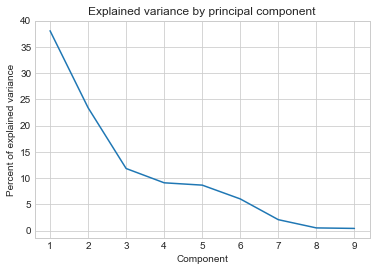

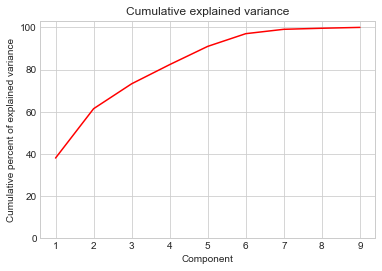

,Explained,Cumulative
Component,,
1,38.055274,38.055274
2,23.391152,61.446426
3,11.813462,73.259889
4,9.093348,82.353237
5,8.649830,91.003067
6,6.021531,97.024598
7,2.069311,99.093909
8,0.501013,99.594922
9,0.405078,100.000000


In [18]:
# perform PCA on scaled training dataset
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train_scaled)

pca_results = pd.DataFrame(pca.explained_variance_ratio_)
pca_results.columns = ['Explained']
pca_results['Cumulative'] = np.cumsum(pca.explained_variance_ratio_)
pca_results = pca_results*100
pca_results.index = range(1, 10)
pca_results.index.name = 'Component'

# visualize results
plt.plot(pca_results['Explained'])
plt.title('Explained variance by principal component')
plt.ylabel('Percent of explained variance')
plt.xlabel('Component')
plt.show()

plt.plot(pca_results['Cumulative'], color='red')
plt.title('Cumulative explained variance')
plt.ylabel('Cumulative percent of explained variance')
plt.xlabel('Component')
plt.ylim(ymin=0)
plt.show()

pca_results

___
The results of PCA show that the first 6 components explain almost 97% of the variance, and the first 7 explain more than 99% of the variance. Since we started with 9 variables, these results show that there is at least 2-3 variables' worth of redundancy in the data due to covariance. 
___

### Logistic Regression

The first model to evaluate is logistic regression.
___

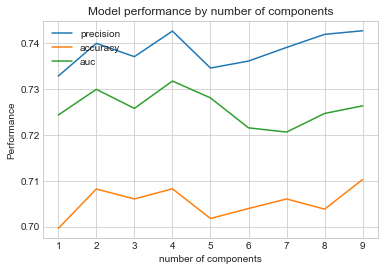

In [69]:
# evaluate model performance with various number of components
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def plot_components(model, train_scaled, X_train, y_train):
    ''' plot model performance metrics vs number of PCA components '''
    cv_scores = pd.DataFrame()

    for n_components in range(1, 10):    
        pca = PCA(n_components=n_components)
        train_pca = pca.fit_transform(train_scaled)
        train_pca = pd.DataFrame(train_pca)
        train_pca.set_index(X_train.index, inplace=True)
        train_pca['sex'] = X_train['sex']
        cv_scores.loc[n_components, 'precision'] = cross_val_score(model, X=train_pca, 
                                                                   y=y_train, cv=5, scoring='precision').mean()
        cv_scores.loc[n_components, 'accuracy'] = cross_val_score(model, X=train_pca, 
                                                                  y=y_train, cv=5, scoring='accuracy').mean()
        cv_scores.loc[n_components, 'auc'] = cross_val_score(model, X=train_pca, 
                                                             y=y_train, cv=5, scoring='roc_auc').mean()

    cv_scores.plot()
    plt.title('Model performance by number of components')
    plt.xlabel('number of components')
    plt.ylabel('Performance')
    plt.show()
    
plot_components(LogisticRegression(), train_scaled, X_train, y_train)

___
The performance of the model does seem to improve somewhat with more components, although surprisingly the model is able to perform pretty well already with just the first two components and sex. 4 components looks to yield the best result according to all three metrics, and corresponds with the first elbow point in the explained variance plot.
___

In [38]:
# fit pca with 4 components
pca = PCA(n_components=4)
train_pca = pca.fit_transform(train_scaled)
train_pca = pd.DataFrame(train_pca)
train_pca.set_index(train_trans.index, inplace=True)
train_pca['sex'] = train_trans['sex']

# transform test dataset
test_pca = pca.transform(test_scaled)
test_pca = pd.DataFrame(test_pca)
test_pca.set_index(test_trans.index, inplace=True)
test_pca['sex'] = test_trans['sex']

In [39]:
# tune hyperparameters with cross-validation
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-5, 2, 100)}

logit = LogisticRegression()
logit_grid = GridSearchCV(logit, param_grid, cv=5, return_train_score=False, scoring='precision')
logit_grid.fit(train_pca, y_train)

print(logit_grid.best_params_)
print(logit_grid.best_score_)
cv_results = pd.DataFrame(logit_grid.cv_results_)

{'C': 1e-05}
0.8050640594580093


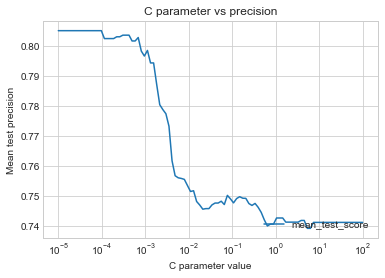

In [40]:
# plot C parameter vs precision
plt.plot(cv_results.param_C, cv_results.mean_test_score)
plt.xscale('log')
plt.title('C parameter vs precision')
plt.xlabel('C parameter value')
plt.ylabel('Mean test precision')
plt.legend(loc='lower right')
plt.show()

The model performs with high precision at C values less than 10^-4. Precision was chosen as the evaluation metric here due to the fact that this model will best serve as a rule-in test; therefore, we want to maximize the positive predictive power of the model.

In [66]:
# evaluate model performance on test data
from sklearn.metrics import confusion_matrix

logit_model = logit_grid.best_estimator_
logit_model.fit(train_pca, y_train)

y_pred = pd.Series(logit_model.predict(test_pca))
matrix = confusion_matrix(y_test, y_pred)

print('confusion matrix: \n', matrix)
print('accuracy: ', logit_model.score(test_pca, y_test))
print('precision: ', matrix[1, 1]/np.sum(matrix[:,1]))
print('specificity: ', matrix[0, 0]/np.sum(matrix[0,:]))
print('sensitivity: ', matrix[1, 1]/np.sum(matrix[1,:]))

confusion matrix: 
 [[16 18]
 [17 66]]
accuracy:  0.7008547008547008
precision:  0.7857142857142857
specificity:  0.47058823529411764
sensitivity:  0.7951807228915663


___
### Random Forest

The next model to try is random forest. 

Random forest is inherently insensitive to skew, scaling, and excess features, so it can be trained directly on the original training data, without preprocessing.
___

In [65]:
# optimize hyperparameters for random forest
# warning: this cell is computationally intensive - do not rerun
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
params = {'n_estimators': range(100, 501, 100),
          'max_depth': [30, 50, 70, 90],
          'min_samples_leaf': [2, 3, 4, 5],
          'max_features': [None, 'auto']}
rf_grid = GridSearchCV(rf, params, cv=5, scoring='precision', n_jobs=7)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.7497679629405783
{'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 100}


In [77]:
# evaluate model performance on test data
rf_model = rf_grid.best_estimator_
rf_model.fit(X_train, y_train)

y_pred = pd.Series(rf_model.predict(X_test))
matrix = confusion_matrix(y_test, y_pred)

print('confusion matrix: \n', matrix)
print('accuracy: ', rf_model.score(X_test, y_test))
print('precision: ', matrix[1, 1]/np.sum(matrix[:,1]))
print('specificity: ', matrix[0, 0]/np.sum(matrix[0,:]))
print('sensitivity: ', matrix[1, 1]/np.sum(matrix[1,:]))

confusion matrix: 
 [[ 8 26]
 [ 4 79]]
accuracy:  0.7435897435897436
precision:  0.7523809523809524
specificity:  0.23529411764705882
sensitivity:  0.9518072289156626


___
While random forest returns a higher accuracy than logistic regression, it has a lower precision. Furthermore, an inspection of the confusion matrix reveals it is classifying the vast majority of subjects as having liver disease. This is not as useful as the logistic regression model.
___

___
### Support Vector Machine

SVM is the next model to test. 

SVM is sensitive to scaling and skew, so the deskewed, standardized data will be used here.
___

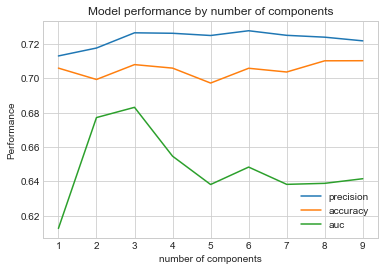

In [68]:
from sklearn.svm import SVC

# visualize effect of component number on SVM performance
plot_components(SVC(), train_scaled, X_train, y_train)

___
SVM performs best with 3 components.
___

In [70]:
# fit pca with 3 components
pca = PCA(n_components=3)
train_pca = pca.fit_transform(train_scaled)
train_pca = pd.DataFrame(train_pca)
train_pca.set_index(train_trans.index, inplace=True)
train_pca['sex'] = train_trans['sex']

# transform test dataset
test_pca = pca.transform(test_scaled)
test_pca = pd.DataFrame(test_pca)
test_pca.set_index(test_trans.index, inplace=True)
test_pca['sex'] = test_trans['sex']

In [73]:
# tune hyperparameters with cross-validation
svm = SVC()

params = {'C': np.logspace(-2, 2, 20), 
          'gamma': np.logspace(-2, 2, 20)}

svm_grid = GridSearchCV(svm, params, cv=5, scoring='precision', n_jobs=7)

svm_grid.fit(train_pca, y_train)
print(svm_grid.best_params_)
print(svm_grid.best_score_)

{'C': 23.357214690901213, 'gamma': 1.2742749857031335}
0.7909732678877546


In [74]:
# evaluate model performance on test data
svm_model = svm_grid.best_estimator_
svm_model.fit(train_pca, y_train)

y_pred = pd.Series(svm_model.predict(test_pca))
matrix = confusion_matrix(y_test, y_pred)

print('confusion matrix: \n', matrix)
print('accuracy: ', svm_model.score(test_pca, y_test))
print('precision: ', matrix[1, 1]/np.sum(matrix[:,1]))
print('specificity: ', matrix[0, 0]/np.sum(matrix[0,:]))
print('sensitivity: ', matrix[1, 1]/np.sum(matrix[1,:]))

confusion matrix: 
 [[15 19]
 [16 67]]
accuracy:  0.7008547008547008
precision:  0.7790697674418605
specificity:  0.4411764705882353
sensitivity:  0.8072289156626506


In [65]:
# try decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_features=None)
params = {'max_depth': range(10, 101, 10), 
          'min_samples_leaf': range(2, 10, 1)}
grid_tree = GridSearchCV(tree, params, cv=5, scoring='accuracy', n_jobs=7)
grid_tree.fit(X_train, y_train)
print(grid_tree.best_score_)
print(grid_tree.best_params_)

0.6979405034324943
{'max_depth': 10, 'min_samples_leaf': 9}


In [68]:
# try Gaussian process
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import cross_val_score

gauss = GaussianProcessClassifier()
score = cross_val_score(gauss, X_train, y_train, cv=5, scoring='accuracy', n_jobs=7)
print(score.mean())

0.7323406478578892


In [69]:
# try voting between RF, SVM, GaussianProcess

from sklearn.ensemble import VotingClassifier

models = [('rf', grid_rf.best_estimator_),
          ('svm', grid_svm.best_estimator_),
          ('gauss', GaussianProcessClassifier())]
voter = VotingClassifier(estimators=models, voting='hard')
score = cross_val_score(voter, X_train, y_train, cv=5, scoring='accuracy', n_jobs=7)
print(score.mean())

0.7483542319749216


In [70]:
voter.fit(X_train, y_train)
voter.score(X_test, y_test)

C:\Users\Nils\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6986301369863014